In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import keras
from keras.models import  Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# 1. Loading The Data

In [3]:
# Display the dataset
df = pd.read_csv("TSLA.csv")
print("Number of Rows and columns: ", df.shape)
df.head()

Number of Rows and columns:  (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


# 2. Feature Scaling

In [4]:
"""
The next step is to split the data into training and test sets to avoid overfitting and to be able to investigate the generalization ability of our model
"""

training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[:800, 1:2].values

In [5]:
# It’s a good idea to normalize the data before model fitting. This will boost the performance.
# Feature Scaling
sc = MinMaxScaler(feature_range= (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
# We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).

(740, 60, 1)


# 3. Building The Model

In [6]:
"""
Now, it’s time to build the model. We will build the LSTM with 50 neurons and 4 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the MSE loss function and the Adam stochastic gradient descent optimizer.
"""
model = Sequential()

# Adding the first LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding the second LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding the third LSTM layer and some Dropout regularization
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
    
# Adding the fourth LSTM layer and some Dropout regularization
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Display model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [7]:
%%time
# Compiling The Model:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting The Model to the Training set
model.fit(X_train, y_train, epochs = 500, batch_size = 32)

Epoch 1/500
24/24 [==============================] - 11s 76ms/step - loss: 0.0607
Epoch 2/500
24/24 [==============================] - 2s 72ms/step - loss: 0.0157
Epoch 3/500
24/24 [==============================] - 2s 71ms/step - loss: 0.0129
Epoch 4/500
24/24 [==============================] - 2s 75ms/step - loss: 0.0111
Epoch 5/500
24/24 [==============================] - 2s 75ms/step - loss: 0.0126
Epoch 6/500
24/24 [==============================] - 2s 72ms/step - loss: 0.0123
Epoch 7/500
24/24 [==============================] - 2s 71ms/step - loss: 0.0108
Epoch 8/500
24/24 [==============================] - 2s 71ms/step - loss: 0.0117
Epoch 9/500
24/24 [==============================] - 2s 72ms/step - loss: 0.0120
Epoch 10/500
24/24 [==============================] - 2s 70ms/step - loss: 0.0105
Epoch 11/500
24/24 [==============================] - 2s 72ms/step - loss: 0.0105
Epoch 12/500
24/24 [==============================] - 2s 71ms/step - loss: 0.0099
Epoch 13/500
24/24 [====

In [8]:
# Prepare The Test Data (Reshape them)
# Getting the predicted stock price of 2017

dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(459, 60, 1)


# 4. Making Predictions with Test Data

In [9]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#rint(predicted_stock_price)

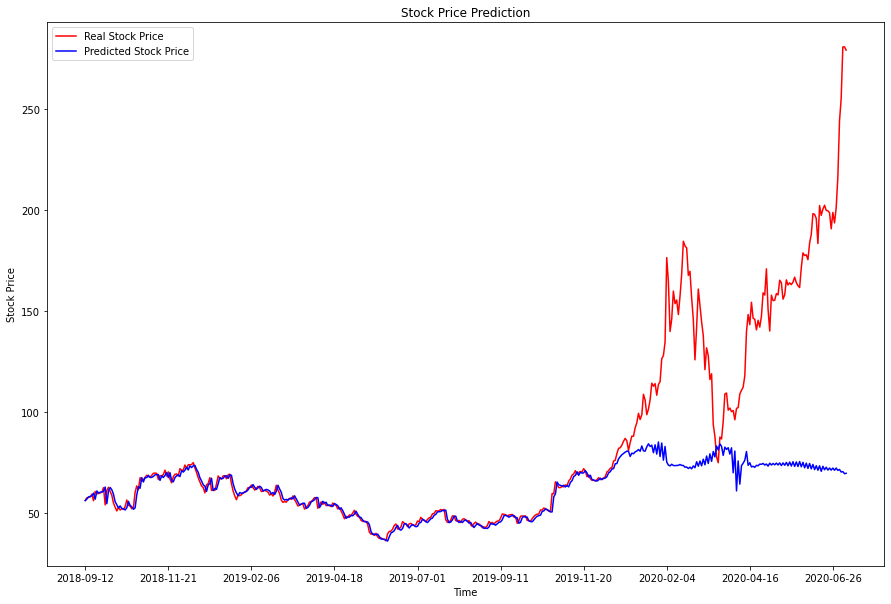

In [10]:
# Visualize the results
plt.rcParams["figure.figsize"] = (15 , 10)
plt.plot(df.loc[800:, 'Date'], dataset_test.values, color = 'red', label = 'Real Stock Price')
plt.plot(df.loc[800:, 'Date'], predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.xticks(np.arange(0, 459, 50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()